In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import math

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
#Amsterdam
amsterdam_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekdays.csv')
amsterdam_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekends.csv')

#Athens
athens_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekdays.csv')
athens_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekends.csv')

#Barcelona
barcelona_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv')
barcelona_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekends.csv')

#Berlin
berlin_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekdays.csv')
berlin_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekends.csv')

#Budapest
budapest_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekdays.csv')
budapest_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekends.csv')

#Lisbon
lisbon_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekdays.csv')
lisbon_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekends.csv')

#London
london_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekdays.csv')
london_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekends.csv')

#Paris
paris_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekdays.csv')
paris_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekends.csv')

#Rome
rome_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekdays.csv')
rome_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekends.csv')

#Vienna
vienna_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekdays.csv')
vienna_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekends.csv')

In [3]:
datasets = [
    (amsterdam_weekdays, "Amsterdam", True),
    (amsterdam_weekend, "Amsterdam", False),
    (athens_weekdays, "Athens", True),
    (athens_weekend, "Athens", False),
    (barcelona_weekdays, "Barcelona", True),
    (barcelona_weekend, "Barcelona", False),
    (berlin_weekdays, "Berlin", True),
    (berlin_weekend, "Berlin", False),
    (budapest_weekdays, "Budapest", True),
    (budapest_weekend, "Budapest", False),
    (lisbon_weekdays, "Lisbon", True),
    (lisbon_weekend, "Lisbon", False),
    (london_weekdays, "London", True),
    (london_weekend, "London", False),
    (paris_weekdays, "Paris", True),
    (paris_weekend, "Paris", False),
    (rome_weekdays, "Rome", True),
    (rome_weekend, "Rome", False),
    (vienna_weekdays, "Vienna", True),
    (vienna_weekend, "Vienna", False)
]

df = pd.DataFrame()

for data, city, is_weekday in datasets:
    data['city'] = city
    data['weekday'] = is_weekday
    df = pd.concat([df, data], ignore_index=True)

df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

print(df.head())
print(df.shape)

      realSum     room_type  room_shared  room_private  person_capacity  \
0  194.033698  Private room        False          True              2.0   
1  344.245776  Private room        False          True              4.0   
2  264.101422  Private room        False          True              2.0   
3  433.529398  Private room        False          True              4.0   
4  485.552926  Private room        False          True              2.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0              False      1    0                10.0   
1              False      0    0                 8.0   
2              False      0    1                 9.0   
3              False      0    1                 9.0   
4               True      0    0                10.0   

   guest_satisfaction_overall  ...      dist  metro_dist  attr_index  \
0                        93.0  ...  5.022964    2.539380   78.690379   
1                        85.0  ...  0.488389    0.239404  631.176378

In [4]:
# path = "/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv"
# df = pd.read_csv(path, index_col=0)
# df.head()

# Data Preposessing

## Add data shuffle

In [5]:
np.random.seed(144)
df = df.sample(frac=1).reset_index(drop=True)

## DEALING WITH MISSING VALUES

In [6]:
df.describe()

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128
std,327.948386,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263
min,34.779339,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000
25%,148.752174,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510
50%,211.343089,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690
75%,319.694287,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885
max,18545.450285,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410


In [7]:
df.shape

(51707, 21)

In [8]:
df_complete = df.dropna()
df_complete.shape

(51707, 21)

## FINDING OUTLIERS

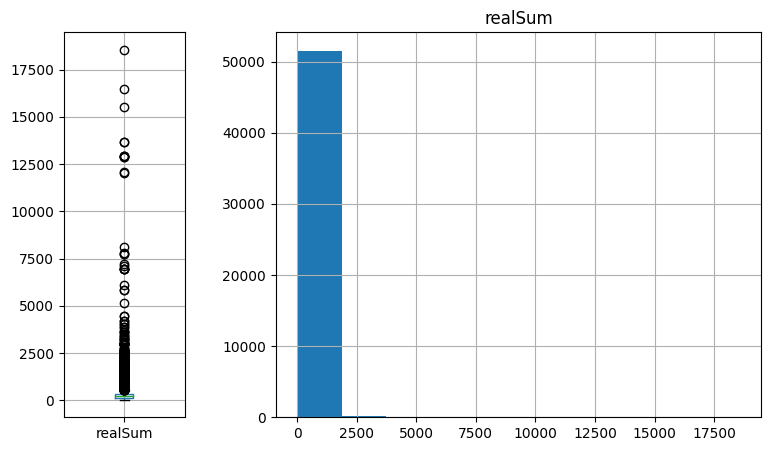

In [9]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df.boxplot(column='realSum',ax=axes[0]);
df.hist(column='realSum', ax=axes[1]);

In [10]:
Q1 = df['realSum'].quantile(0.25)
Q3 = df['realSum'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

(148.75217370869953, 319.69428651318856, 170.94211280448903)

In [11]:
small_outliers = df['realSum'] < (Q1 - 1.5 * IQR)
big_outliers = df['realSum'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(0, 3662)

In [12]:
df['realSum'][small_outliers | big_outliers].head()

60     698.806972
66     956.983937
83     593.852160
95     636.702364
99    2311.738714
Name: realSum, dtype: float64

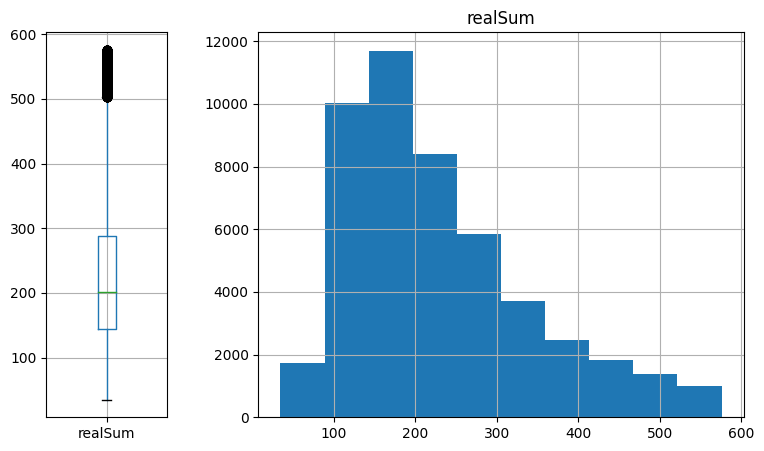

In [13]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df[~(small_outliers | big_outliers)].boxplot(column='realSum',ax=axes[0]);
df[~(small_outliers | big_outliers)].hist(column='realSum', ax=axes[1]);

In [14]:
df_clean = df[~(small_outliers | big_outliers)]
df_clean.shape

(48045, 21)

In [15]:
df_clean.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
city                           object
weekday                          bool
dtype: object

In [16]:
# Identifying categorical and numerical columns
categorical_cols = [col for col in df_clean.columns if df_clean[col].dtype in ['object', 'bool']]
numerical_cols = [col for col in df_clean.columns if df_clean[col].dtype in ['int64', 'float64'] and col != 'realSum']

# Adjust transformers if necessary
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# Update preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df_clean.drop('realSum', axis=1))

# Check transformed feature names and dimensions
transformed_features = preprocessor.transformers_[0][1].get_feature_names_out(numerical_cols).tolist() + \
                       preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols).tolist()

print(transformed_features)
print(df_transformed.shape)

['person_capacity', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'room_shared_False', 'room_shared_True', 'room_private_False', 'room_private_True', 'host_is_superhost_False', 'host_is_superhost_True', 'city_Amsterdam', 'city_Athens', 'city_Barcelona', 'city_Berlin', 'city_Budapest', 'city_Lisbon', 'city_London', 'city_Paris', 'city_Rome', 'city_Vienna', 'weekday_False', 'weekday_True']
(48045, 35)


# Prepare Training Data

In [17]:
# y = df_clean['realSum'].values

# # Create Train Data and Test Data
# X_train, X_test, y_train, y_test = train_test_split(df_transformed, y, test_size=0.2, random_state=42)
# X_train = torch.tensor(X_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

# # Create DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
y = df_clean['realSum'].values

# Split Test Data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_transformed, y, test_size=0.2, random_state=42)

# Split Validation Data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define SVM Model

In [19]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [20]:
class SVR(nn.Module):
    def __init__(self, n_features):
        super(SVR, self).__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

In [21]:
def epsilon_insensitive_loss(outputs, targets, epsilon=0.1):
    errors = torch.abs(targets - outputs.squeeze())

    loss = torch.mean(torch.max(errors - epsilon, torch.zeros_like(errors)))
    return loss

In [22]:
model = SVR(X_train.shape[1]).to(device)
print(model)

SVR(
  (linear): Linear(in_features=35, out_features=1, bias=True)
)


In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

In [24]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0001):  
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.reset()

    def reset(self):
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:  
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")
        else:
            self.best_score = score
            self.epochs_no_improve = 0

# Model Training

In [25]:
# def train_model(model, train_loader, epochs=1000, epsilon=0.1):
#     model.train() 
#     for epoch in range(epochs):
#         total_loss = 0 
#         for data, target in train_loader:
#             optimizer.zero_grad()
#             output = model(data)
#             loss = epsilon_insensitive_loss(output, target, epsilon)
#             loss.backward()  
#             optimizer.step() 
#             total_loss += loss.item() 
#         if (epoch + 1) % 10 == 0:
#             average_loss = total_loss / len(train_loader)
#             print(f'Epoch {epoch+1}, Average Loss: {average_loss}')

In [26]:
def train_model(model, train_loader, val_loader, optimizer, epochs=float('inf'), epsilon=0.1):
    early_stopping = EarlyStopping(patience=10, verbose=True)
    
    epoch = 0
    while not early_stopping.early_stop and epoch < epochs:
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = epsilon_insensitive_loss(output, target, epsilon)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
        val_loss /= len(val_loader)

        print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')
        early_stopping(val_loss)
        
        epoch += 1

    if epoch >= epochs:
        print("Reached maximum number of epochs")

In [27]:
train_model(model, train_loader, val_loader, optimizer)

Epoch 1, Validation Loss: 208.94528632763996
Epoch 2, Validation Loss: 190.94760313728787
Epoch 3, Validation Loss: 173.77133997228762
Epoch 4, Validation Loss: 157.60315598241542
Epoch 5, Validation Loss: 142.94449135483495
Epoch 6, Validation Loss: 130.23213534323585
Epoch 7, Validation Loss: 119.6413345842172
Epoch 8, Validation Loss: 110.98688648552294
Epoch 9, Validation Loss: 104.11379893726071
Epoch 10, Validation Loss: 98.6677462849396
Epoch 11, Validation Loss: 94.31829581355417
Epoch 12, Validation Loss: 90.88777857900455
Epoch 13, Validation Loss: 88.13547667446515
Epoch 14, Validation Loss: 85.91710448107183
Epoch 15, Validation Loss: 84.12007856053232
Epoch 16, Validation Loss: 82.62921006158487
Epoch 17, Validation Loss: 81.391487374211
Epoch 18, Validation Loss: 80.34628990628072
Epoch 19, Validation Loss: 79.47993691551764
Epoch 20, Validation Loss: 78.72500304670524
Epoch 21, Validation Loss: 78.08214018360668
Epoch 22, Validation Loss: 77.51590309395695
Epoch 23, Vali

# Test Results

In [28]:
def predict(model, test_loader):
    model.eval() 
    predictions = []
    with torch.no_grad():  
        for data in test_loader:
            inputs = data[0]
            outputs = model(inputs)
            predictions.append(outputs)

    predictions = torch.cat(predictions).view(-1)
    return predictions

In [29]:
model_predictions = predict(model, test_loader)

In [30]:
predictions_np = model_predictions.numpy()
print("Sample predictions:", predictions_np[:10])

Sample predictions: [119.6505   182.26465  148.3581   138.71767  135.77919  114.38396
 209.71564  189.74405  196.99881  122.527405]


In [31]:
# Define MSE & MAE
def mean_squared_error(predictions, targets):
    return ((predictions - targets) ** 2).mean()

def mean_absolute_error(predictions, targets):
    return torch.abs(predictions - targets).mean()

In [32]:
def evaluate_model(model, test_loader):
    model.eval() 
    predictions, actuals = [], []
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            predictions.append(output)
            actuals.append(target)
    
    predictions = torch.cat(predictions).view(-1)
    actuals = torch.cat(actuals).view(-1)
    
    mse = mean_squared_error(predictions, actuals)
    mae = mean_absolute_error(predictions, actuals)
    print(f'Mean Squared Error: {mse.item()}')
    print(f'Mean Absolute Error: {mae.item()}')

    return mse, mae

In [33]:
evaluate_model(model, test_loader)

Mean Squared Error: 11318.5615234375
Mean Absolute Error: 72.42217254638672


(tensor(11318.5615), tensor(72.4222))

# Define MLP Model

In [34]:
class MLPRegressor(nn.Module):
    def __init__(self, input_size, output_activation=None):
        super(MLPRegressor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.output_activation = output_activation

    def forward(self, x):
        x = self.network(x)
        if self.output_activation:
            x = self.output_activation(x)
        return x

In [35]:
# Determine the number of features from the training data
input_size = X_train.shape[1]

# Initialize the model
mlp_model = MLPRegressor(input_size, output_activation=nn.ReLU()).to(device)
print(mlp_model)

# Choose an optimizer and loss function
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

MLPRegressor(
  (network): Sequential(
    (0): Linear(in_features=35, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (output_activation): ReLU()
)


In [36]:
def train(model, train_loader, optimizer, criterion):
    model.train()  # Set the model to training mode
    total_loss = 0
    for data, targets in train_loader:
        optimizer.zero_grad()  # Clear existing gradients
        outputs = model(data)  # Forward pass
        loss = criterion(outputs, targets)
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, targets in val_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [37]:
early_stopping = EarlyStopping(patience=10, verbose=True)

for epoch in range(1000):  
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Stopping early due to no improvement")
        break

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 1: Train Loss: 17397.8944, Val Loss: 16923.0763
Epoch 2: Train Loss: 17392.1599, Val Loss: 16923.0763
Epoch 3: Train Loss: 17412.9743, Val Loss: 16923.0763
Epoch 4: Train Loss: 17396.3111, Val Loss: 16923.0763
Epoch 5: Train Loss: 17392.4895, Val Loss: 16923.0763
Epoch 6: Train Loss: 17385.8294, Val Loss: 16923.0763
Epoch 7: Train Loss: 17401.6540, Val Loss: 16923.0763
Epoch 8: Train Loss: 17393.7112, Val Loss: 16923.0763
Epoch 9: Train Loss: 17393.3564, Val Loss: 16923.0763
Epoch 10: Train Loss: 17404.3383, Val Loss: 16923.0763
Epoch 11: Train Loss: 17391.4843, Val Loss: 16923.0763
Epoch 12: Train Loss: 17390.2270, Val Loss: 16923.0763
Epoch 13: Train Loss: 17401.5456, Val Loss: 16923.0763
Epoch 14: Train Loss: 17390.5601, Val Loss: 16923.0763
Epoch 15: Train Loss: 17373.7436, Val Loss: 16923.0763
Epoch 16: Train Loss: 17400.3592, Val Loss: 16923.0763
Epoch 17: Train Loss: 17386.8514, Val Loss: 16923.0763
Epoch 18: Train Loss: 17393.1558, Val Loss: 16923.0763
Epoch 19: Train Los

In [38]:
model_predictions = predict(mlp_model, test_loader)

In [39]:
predictions_np = model_predictions.numpy()
print("Sample predictions:", predictions_np[:10])

Sample predictions: [0.01341024 0.02131699 0.06009202 0.04324853 0.0343709  0.04801399
 0.02910771 0.05093344 0.03041739 0.03600008]


In [40]:
evaluate_model(mlp_model, test_loader)

Mean Squared Error: 64709.640625
Mean Absolute Error: 228.06268310546875


(tensor(64709.6406), tensor(228.0627))